In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from joblib import Parallel, delayed
from torch.utils.data import Dataset, DataLoader
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast
import numpy as np
from sudoku import Sudoku
from tqdm.notebook import tqdm
import pygame
import time
from random import randint, shuffle

pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\giuse\AppData\Local\pypoetry\Cache\virtualenvs\torch-cuda-py312-jZb9TTup-py3.12\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
class SudokuDataset(Dataset):
    def __init__(self, data):
        self.puzzles = [torch.tensor(puzzle, dtype=torch.float).unsqueeze(0) for puzzle, _ in data]
        self.solutions = [torch.tensor(solution, dtype=torch.long) for _, solution in data]

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        return self.puzzles[idx], self.solutions[idx]

In [3]:
def swap_rows(grid1, grid2):
    """Swap two random rows within the same block for both puzzle and solution."""
    block = np.random.randint(0, 3)
    row1, row2 = np.random.choice(range(block * 3, (block + 1) * 3), size=2, replace=False)
    grid1[[row1, row2]] = grid1[[row2, row1]]
    grid2[[row1, row2]] = grid2[[row2, row1]]
    return grid1, grid2

def swap_columns(grid1, grid2):
    """Swap two random columns within the same block for both puzzle and solution."""
    block = np.random.randint(0, 3)
    col1, col2 = np.random.choice(range(block * 3, (block + 1) * 3), size=2, replace=False)
    grid1[:, [col1, col2]] = grid1[:, [col2, col1]]
    grid2[:, [col1, col2]] = grid2[:, [col2, col1]]
    return grid1, grid2

def rotate_grid(grid1, grid2):
    """Rotate both puzzle and solution by 90, 180, or 270 degrees."""
    k = np.random.choice([1, 2, 3])
    return np.rot90(grid1, k), np.rot90(grid2, k)

def augment_grid(puzzle, solution):
    """Apply random transformations to both puzzle and solution."""
    transformations = [swap_rows, swap_columns, rotate_grid]
    shuffle(transformations)
    for transform in transformations:
        puzzle, solution = transform(puzzle, solution)
    return puzzle, solution

In [4]:
def generate_single_sudoku():
    grid = Sudoku.from_dim(3)
    solution = np.array(grid.grid, dtype=np.int8)
    grid.remove_numbers(randint(10, 55))
    puzzle = np.array(grid.grid, dtype=np.int8)
    return puzzle, solution

def generate_dataset(num_samples, n_jobs=4):
    data = Parallel(n_jobs=n_jobs)(
        delayed(generate_single_sudoku)() for _ in tqdm(range(num_samples), desc="Generating Sudokus")
    )
    puzzles, solutions = zip(*data)
    
    # Applichiamo data augmentation in modo consistente a puzzle e soluzione
    augmented_data = []
    for puzzle, solution in tqdm(zip(puzzles, solutions), total=len(puzzles), desc="Augmenting Data"):
        puzzle_aug, solution_aug = augment_grid(puzzle, solution)
        augmented_data.append((puzzle_aug, solution_aug))
    
    all_puzzles = np.concatenate((puzzles, [p[0] for p in augmented_data]))
    all_solutions = np.concatenate((solutions, [p[1] for p in augmented_data]))
    
    return list(zip(all_puzzles, all_solutions))

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.batch_norm1(self.conv1(x)))
        out = self.batch_norm2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=81):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Forma (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Espandi self.pe lungo la dimensione batch per poter essere sommato a x
        pe_expanded = self.pe[:, :x.size(1), :].expand(x.size(0), -1, -1)  # Espande pe a (batch_size, 81, 256)
        return x + pe_expanded.to(x.device)  # Somma con x

class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet, self).__init__()

        # Layer Convoluzionali con Residual Blocks
        self.layer1 = ResidualBlock(1, 64)
        self.layer2 = ResidualBlock(64, 128)
        self.layer3 = ResidualBlock(128, 256)
        self.layer4 = ResidualBlock(256, 256)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((9, 9))  # Restituisce (batch_size, 256, 9, 9)

        # Modulo LSTM
        self.lstm = nn.LSTM(input_size=256, hidden_size=512, num_layers=2, batch_first=True, dropout=0.3)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model=256)  # d_model corrisponde al numero di canali

        # Meccanismo di Attenzione
        self.attention = nn.Linear(512, 1)

        # Fully connected layer finale
        self.fc1 = nn.Linear(512, 9 * 9 * 9)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Passaggio attraverso i blocchi residuali
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # (batch_size, 256, 9, 9)

        # Appiattisce a (batch_size, 81, 256)
        x = x.permute(0, 2, 3, 1).view(x.size(0), 81, 256)

        # Aggiungi Positional Encoding: deve essere applicato sulla dimensione 81, che rappresenta le celle
        x = self.positional_encoding(x)

        # Passaggio attraverso l'LSTM
        x, _ = self.lstm(x)  # output LSTM, la sequenza è di lunghezza 81 con 512 unità nascoste

        # Attenzione
        attn_weights = torch.softmax(self.attention(x), dim=1)
        x = torch.sum(attn_weights * x, dim=1)

        # Passaggio attraverso il fully connected layer
        x = self.dropout(x)
        x = self.fc1(x)

        # Output reshape in (batch_size, 9, 9, 9) per la previsione del Sudoku
        return x.view(-1, 9, 9, 9)

In [6]:
data = generate_dataset(num_samples=100000, n_jobs=8)
test_data = generate_dataset(num_samples=10, n_jobs=8)

Generating Sudokus:   0%|          | 0/100000 [00:00<?, ?it/s]

Augmenting Data:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating Sudokus:   0%|          | 0/10 [00:00<?, ?it/s]

Augmenting Data:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
print(len(data), len(test_data))

200000 20


In [8]:
dataset = SudokuDataset(data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)

In [9]:
test_dataset = SudokuDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)

In [10]:
model = SudokuNet().to('cuda')
criterion = nn.CrossEntropyLoss(ignore_index=-1).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
scaler = GradScaler(device='cuda')

In [11]:
def validate(model, dataloader):
    model.eval()
    total_correct = 0
    total_numbers = 0
    
    with torch.no_grad():
        for puzzles, solutions in dataloader:
            puzzles, solutions = puzzles.to('cuda'), solutions.to('cuda')
            output = model(puzzles)
            output = output.view(-1, 9) 
            _, predicted = torch.max(output, 1)
            
            predicted = predicted.view(puzzles.size(0), 9, 9) + 1
            solutions = solutions.view(puzzles.size(0), 9, 9)
            
            correct = (predicted == solutions).sum().item()
            total_correct += correct
            total_numbers += puzzles.size(0) * 81
    
    accuracy = total_correct / total_numbers
    return accuracy

In [12]:
def earlyStopping(val_losses, patience, delta, num_epochs):
    count = patience
    if len(val_losses) < patience: # se non abbiamo ancora abbastanza epoche per fare confronti
        return False
    elif len(val_losses) == num_epochs - 1: # se siamo all'ultima epoca
        return False
    else:
        last_losses_sum = sum(val_losses[-patience:])
        last_losses_avg = last_losses_sum / patience
        for i in range(1, patience+1):
            if val_losses[-i] < last_losses_avg + delta/2 and val_losses[-i] > last_losses_avg - delta/2:
                count -= 1
    return count <= 0

In [13]:
avg_losses = []
accuracies = []

num_epochs = 20
for epoch in tqdm(range(num_epochs), desc="Training", leave=False):
    model.train()
    losses = []
    for inputs, targets in dataloader:
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            outputs = outputs.view(-1, 9)
            targets = targets.view(-1) - 1
            loss = criterion(outputs, targets)
            
        losses.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
    scheduler.step()
    avg_losses.append(sum(losses) / len(losses))
    accuracy = validate(model, dataloader)
    accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_losses[-1]:.3f}, Validation Accuracy: {accuracy:.3f}')
    if earlyStopping(avg_losses, 5, 0.005, num_epochs) or accuracy > 0.99:
        print("Early stopping with accuracy: ", accuracy * 100, "%")
        pygame.mixer.init()
        for i in range(3):
            pygame.mixer.Sound("msg.mp3").play()
            time.sleep(2.5)
        pygame.mixer.quit()
        break

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 2.093, Validation Accuracy: 0.242
Epoch 2/20, Loss: 1.708, Validation Accuracy: 0.446
Epoch 3/20, Loss: 1.363, Validation Accuracy: 0.669
Epoch 4/20, Loss: 1.063, Validation Accuracy: 0.766
Epoch 5/20, Loss: 0.886, Validation Accuracy: 0.812
Epoch 6/20, Loss: 0.771, Validation Accuracy: 0.841
Epoch 7/20, Loss: 0.667, Validation Accuracy: 0.863
Epoch 8/20, Loss: 0.620, Validation Accuracy: 0.876
Epoch 9/20, Loss: 0.581, Validation Accuracy: 0.885
Epoch 10/20, Loss: 0.550, Validation Accuracy: 0.893
Epoch 11/20, Loss: 0.524, Validation Accuracy: 0.898
Epoch 12/20, Loss: 0.502, Validation Accuracy: 0.905
Epoch 13/20, Loss: 0.464, Validation Accuracy: 0.914
Epoch 14/20, Loss: 0.450, Validation Accuracy: 0.918
Epoch 15/20, Loss: 0.438, Validation Accuracy: 0.921
Epoch 16/20, Loss: 0.428, Validation Accuracy: 0.924
Epoch 17/20, Loss: 0.418, Validation Accuracy: 0.927
Epoch 18/20, Loss: 0.409, Validation Accuracy: 0.930
Epoch 19/20, Loss: 0.385, Validation Accuracy: 0.936
Ep

In [14]:
torch.save(model.state_dict(), 'model.pt')

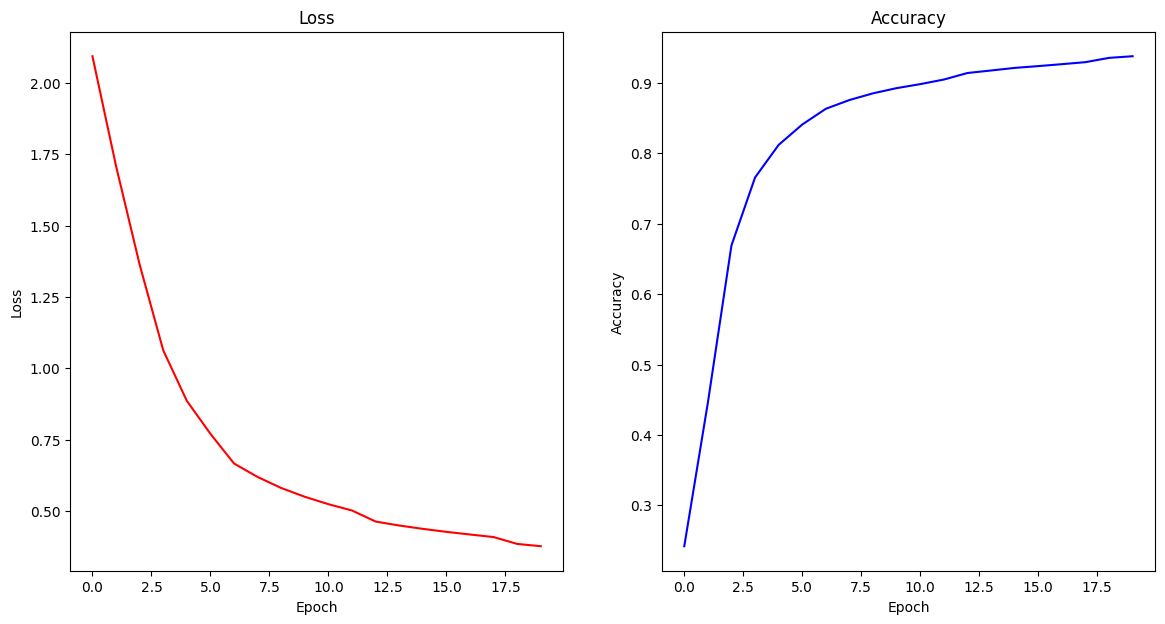

In [15]:
import matplotlib.pyplot as plt

plot_values = [avg_losses, accuracies]
plot_labels = ['Loss', 'Accuracy']


def plot_data(data, labels):
    subplots, ax = plt.subplots(1, len(data), figsize=(14, 7))
    # Loss
    ax[0].plot(data[0], '-r')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel(labels[0])
    ax[0].set_title(labels[0])
    # Accuracy
    ax[1].plot(data[1], '-b')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel(labels[1])
    ax[1].set_title(labels[1])

plot_data(plot_values, plot_labels)

In [16]:
# Test
model.eval()
count = 0
total = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 3)
        predicted = predicted + 1
        for j in range(inputs.size(0)):
            puzzle = inputs[j].cpu().numpy().reshape(9, 9).astype(int)
            solution = targets[j].cpu().numpy().reshape(9, 9).astype(int)
            prediction = predicted[j].cpu().numpy().reshape(9, 9).astype(int)
            incorrect = (prediction != solution)
            num_incorrect = np.sum(incorrect)
            if num_incorrect > 0:
                count += 1
                print(f'Puzzle {j + i * inputs.size(0)}:')
                print('Input Puzzle:')
                print(puzzle)
                print('Predicted Solution:')
                print(prediction)
                print('Correct Solution:')
                print(solution)
                print(f'Number of incorrect cells: {num_incorrect}')
                print('-' * 30)
            total += 1

print(count)
print(total)

Puzzle 0:
Input Puzzle:
[[0 1 8 0 9 4 6 2 7]
 [5 2 7 6 1 8 9 0 3]
 [9 4 6 0 7 3 5 1 0]
 [0 5 9 8 3 7 4 0 1]
 [0 7 3 0 4 5 8 9 2]
 [1 8 4 9 6 2 7 3 5]
 [4 9 2 0 5 1 3 8 6]
 [7 3 0 4 8 6 2 5 9]
 [8 6 5 3 2 9 1 7 4]]
Predicted Solution:
[[3 1 8 5 9 4 6 2 7]
 [5 2 7 6 1 8 9 4 3]
 [9 4 6 2 7 3 5 1 8]
 [2 5 9 8 3 7 4 6 1]
 [2 7 3 1 4 5 8 9 2]
 [1 8 4 9 6 2 7 3 5]
 [4 9 2 7 5 1 3 8 6]
 [7 3 1 4 8 6 2 5 9]
 [8 6 5 3 2 9 1 7 4]]
Correct Solution:
[[3 1 8 5 9 4 6 2 7]
 [5 2 7 6 1 8 9 4 3]
 [9 4 6 2 7 3 5 1 8]
 [2 5 9 8 3 7 4 6 1]
 [6 7 3 1 4 5 8 9 2]
 [1 8 4 9 6 2 7 3 5]
 [4 9 2 7 5 1 3 8 6]
 [7 3 1 4 8 6 2 5 9]
 [8 6 5 3 2 9 1 7 4]]
Number of incorrect cells: 1
------------------------------
1
20


In [17]:
test_data2 = generate_dataset(num_samples=512, n_jobs=8)
test_dataset2 = SudokuDataset(test_data2)
test_dataloader2 = DataLoader(test_dataset2, batch_size=256, shuffle=False, pin_memory=True)

Generating Sudokus:   0%|          | 0/512 [00:00<?, ?it/s]

Augmenting Data:   0%|          | 0/512 [00:00<?, ?it/s]

In [18]:
# Test
model.eval()
count = 0
total = 0

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_dataloader2):
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 3)
        predicted = predicted + 1
        for j in range(inputs.size(0)):
            puzzle = inputs[j].cpu().numpy().reshape(9, 9).astype(int)
            solution = targets[j].cpu().numpy().reshape(9, 9).astype(int)
            prediction = predicted[j].cpu().numpy().reshape(9, 9).astype(int)
            incorrect = (prediction != solution)
            num_incorrect = np.sum(incorrect)
            if num_incorrect > 0:
                count += 1
                print(f'Puzzle {j + i * inputs.size(0)}:')
                print('Input Puzzle:')
                print(puzzle)
                print('Predicted Solution:')
                print(prediction)
                print('Correct Solution:')
                print(solution)
                print(f'Number of incorrect cells: {num_incorrect}')
                print('-' * 30)
            total += 1

print(count)
print(total)

Puzzle 0:
Input Puzzle:
[[1 7 9 0 0 5 6 3 4]
 [6 0 4 0 3 9 1 5 8]
 [8 0 5 6 4 0 0 7 0]
 [0 0 7 5 6 3 2 8 9]
 [5 9 3 2 0 4 0 1 0]
 [2 8 6 9 1 7 5 0 3]
 [0 0 2 3 5 0 8 9 1]
 [0 5 8 1 9 2 0 6 0]
 [9 6 0 0 7 0 3 2 5]]
Predicted Solution:
[[1 7 9 8 2 5 6 3 4]
 [6 2 4 7 3 9 1 5 8]
 [8 3 5 6 4 1 9 7 2]
 [4 4 7 5 6 3 2 8 9]
 [5 9 3 2 8 4 6 1 7]
 [2 8 6 9 1 7 5 4 3]
 [7 4 2 3 5 6 8 9 1]
 [3 5 8 1 9 2 4 6 7]
 [9 6 1 4 7 8 3 2 5]]
Correct Solution:
[[1 7 9 8 2 5 6 3 4]
 [6 2 4 7 3 9 1 5 8]
 [8 3 5 6 4 1 9 7 2]
 [4 1 7 5 6 3 2 8 9]
 [5 9 3 2 8 4 7 1 6]
 [2 8 6 9 1 7 5 4 3]
 [7 4 2 3 5 6 8 9 1]
 [3 5 8 1 9 2 4 6 7]
 [9 6 1 4 7 8 3 2 5]]
Number of incorrect cells: 3
------------------------------
Puzzle 2:
Input Puzzle:
[[0 0 4 7 3 1 9 0 6]
 [0 9 1 5 4 6 3 2 8]
 [0 0 0 9 0 8 7 0 0]
 [9 1 0 4 7 5 0 6 3]
 [0 5 7 8 6 0 4 9 1]
 [4 6 2 3 0 9 0 0 5]
 [6 0 0 2 5 4 1 8 9]
 [0 4 0 0 9 7 6 3 0]
 [1 2 9 6 8 3 5 4 7]]
Predicted Solution:
[[8 2 4 7 3 1 9 5 6]
 [7 9 1 5 4 6 3 2 8]
 [3 3 5 9 2 8 7 1 4]
 [9 1 8 4 7